In [21]:
import numpy as np
import math

class SimpleAgentModel:
    class Donators:
        
        def __init__(self):
            self.med_coef = 0
            self.adv_coef = 0
            self.org_pref = 0
            self.prev_donations = 0
            self.reset()
            
        def reset(self):
            self.med_coef = np.random.beta(2, 2, 100)
            self.adv_coef = np.zeros(100, np.float64)
            self.prev_donations = np.zeros((100, 10), np.uint8)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] > half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            
    class Patients:
        def __init__(self):
            self.med_coef = 0  
            self.adv_coef = 0               
            self.org_pref = 0
            self.choice = 0
            self.p_survival = 0 
            self.visited = 0
            self.budget = 0
            self.count_cured = 0
            self.graph = 0
            self.reset()
            
        def reset(self):
            self.graph = np.random.binomial(n = 1, p = 0.5, size = (100, 100))
            self.med_coef = np.random.beta(2, 2, 100)  #  Какие параметры бета-распредления выставить?
            self.adv_coef = np.zeros(100, np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] < half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
                   
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            self.choice = np.zeros(100, np.int8)
            self.p_survival = np.random.beta(2, 5, 100)  
            self.visited = np.zeros((100, 10), bool)
            self.budget = np.zeros(100, np.int8)
            self.count_cured = np.int8(0)
            
        def new_patient(self, i):
            for j in range(10):
                self.visited[i][j] = False
            self.p_survival[i] = np.random.beta(2, 2)
            self.med_coef[i] = np.random.beta(2, 2)
            self.graph[i] = np.random.binomial(n = 1, p = 0.5, size = 100)
            if self.med_coef[i] < np.float64(0.5):
                self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
            else:
                self.adv_coef[i] = 1 - self.med_coef[i]
            
    class Organizations:
        def __init__(self):
            self.budget = 0
            self.med_budget = 0
            self.adv_budget = 0
            self.med_coef = 0
            self.is_lose = 0
            self.patients = 0
            self.laps = 0
            self.saved_lives = 0
            self.all_patients = 0
            self.tax = 0
            self.reset()
            
        def reset(self, new_tax = 0):
            self.budget = np.zeros(10, np.uint8)
            self.med_budget = np.zeros(10)
            self.adv_budget = np.zeros(10)
            self.med_coef = np.random.beta(2, 2, 10)  #   Какие параметры бета-распредления выставить?
            self.is_lose = np.zeros(10, bool)
            self.patients = [[] for i in range(10)]
            self.laps = np.zeros(10, np.uint32)
            self.saved_lifes = np.zeros(10, np.uint16)
            self.all_patients = np.zeros(10, np.uint16)
            self.tax = new_tax
    
    def __init__(self):
        self.donators = SimpleAgentModel.Donators()
        self.patients = SimpleAgentModel.Patients()
        self.organizations = SimpleAgentModel.Organizations()
        
    def donation(self):
        for i in range(100): 
            ind = np.argmax(self.donators.org_pref[i]) 
            self.donators.prev_donations[i][ind] += 1
            self.organizations.budget[ind] += 1        
            
    def budget_med_or_adv(self):                    #  Сделать долевым!!  
        for i in range(10):
            if self.organizations.budget[i] == 0:
                self.organizations.is_lose[i] = True
            else:
                self.organizations.laps[i] += 1
                self.organizations.med_budget[i] = self.organizations.budget[i] * self.organizations.med_coef[i]
                self.organizations.adv_budget[i] = (self.organizations.budget[i] - self.organizations.med_budget[i]) * (1 - self.organizations.tax)
                self.organizations.budget[i] = 0
        #print(f'{self.organizations.med_budget = }\n{self.organizations.adv_budget = }')

    def choose_organization(self):  
        for i in range(100):
            for j in range(10):
                if self.patients.visited[i][j] or self.organizations.is_lose[j]:
                    self.patients.org_pref[i][j] = -100
                    continue
                a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
            ind = np.argmax(self.patients.org_pref[i]) 
            if self.patients.org_pref[i][ind] == -100:
                for j in range(10):
                    self.patients.visited[i][j] = False
                    if not self.organizations.is_lose[j]:
                        a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                        self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
                ind = np.argmax(self.patients.org_pref[i])
                   
            self.patients.visited[i][ind] = True
            self.patients.choice[i] = ind
            self.organizations.all_patients[ind] += 1
            self.organizations.patients[ind].append(i)
                                                                                                                                                
    def budget_between_patient(self): #  Может ли организация не принять?
        for i in range(10):
            if (self.organizations.is_lose[i]):
                continue
            survive = [self.patients.p_survival[self.organizations.patients[i][j]] for j in range(len(self.organizations.patients[i]))]
            surv_sum = sum(survive)
            proportion = [prob / surv_sum for prob in survive]
            for j in range(len(self.organizations.patients[i])):
                ind = self.organizations.patients[i][j]
                self.patients.budget[ind] = proportion[j] * self.organizations.med_budget[i]            
            self.organizations.patients[i] = []
        
    def survival(self):                 #  поменять коэффициенты в ???
        for i in range(100):            #  logit ~ (0.5, 1) - p выживаемости. 
                                        #  У нас в любом случае высокая вероятность выжить!!

            s_i = (1 / (1 + math.pow(math.e, -(-0.5 + self.patients.p_survival[i] + self.patients.budget[i]) ))) - 0.2
            
            if np.random.binomial(1, s_i): #  Пациент вылечился (Биномиальное распределение)
                self.patients.count_cured += 1
                self.patients.new_patient(i)
                self.organizations.saved_lifes[self.patients.choice[i]] += 1
        
    def set_new_preferences(self):
        for i in range(100):
            for j in range(10):
                if self.organizations.is_lose[j]:
                    self.donators.org_pref[i][j] = -100
                    continue
                a = self.donators.med_coef[i] * self.organizations.med_budget[j] + self.donators.adv_coef[i] * self.organizations.adv_budget[j]
                #self.donators.org_pref[i][j] = np.random.normal(a, 9)
                self.donators.org_pref[i][j] = np.random.normal(a, 9 / (1 + self.donators.prev_donations[i][j]))
        self.organizations.budget = np.zeros(10, np.int8)
        self.organizations.med_budget = np.zeros(10, np.int8)
        self.organizations.adv_budget = np.zeros(10, np.int8)
        
    
    def lap(self):
        self.donation()
        #print('Budgets of org:', end = ' ')
        #for i in range(10):
        #    print(self.organizations.budget[i], end = ', ')
        #print()
        
        self.budget_med_or_adv()
        self.choose_organization()
        
        #print(f'Количество пациентов организации:', end = ' ')
        #for i in range(10):
        #    print(len(self.organizations.patients[i]), end = ', ')
        #print()
        self.budget_between_patient()
        self.survival()
        #print(f'Количество вылечившихся: {self.patients.count_cured}')
        self.set_new_preferences()
        
    def simulation(self):
        self.donators.reset()
        self.patients.reset()
        self.organizations.reset(self.organizations.tax)
        i = 0
        while True:
            i += 1
            self.lap()
            if sum(self.organizations.is_lose == True) == 9:
                winner_ind = 0
                for j in range(10):
                    if not self.organizations.is_lose[j]:
                        winner_ind = j
                        break
                #print(f'laps: {i}, saved: {self.patients.count_cured}, per_lap: {self.patients.count_cured / i}')
                return i, self.organizations.laps, self.organizations.med_coef, self.organizations.saved_lifes, self.organizations.all_patients, winner_ind
            
   

In [23]:
from matplotlib import pyplot as plt
from statistics import mean
import pandas as pd
import scipy.stats as st

tax_results = pd.DataFrame(columns = ['Tax, %', 'Average med_coef', 'Average win_med_coef', 'Av saved fraction', 'Av win saved fraction', 'Av end lap'])


def tax_sim(df, tax = 0., print_status = False):
    total_laps = np.zeros(1000, np.uint16)
    total_med_coef = np.zeros(1000)
    total_saved_lifes = np.zeros(1000)
    total_patients = np.zeros(1000, np.uint16)
    saved_fraction = np.zeros(1000)
    
    game_end = np.zeros(100, np.uint16)
    winner_med = np.zeros(100)
    winner_saved_fraction = np.zeros(100)
    
    Model = SimpleAgentModel()
    Model.organizations.tax = tax
    
    for i in range(100):
        end, laps, med_coef, saved_lifes, total_pat, win_ind = Model.simulation()
        for j in range(i * 10, i * 10 + 10):
            total_laps[j] = laps[j % 10]
            total_med_coef[j] = med_coef[j % 10]
            total_saved_lifes[j] = saved_lifes[j % 10]
            total_patients[j] = total_pat[j % 10]
        #total_laps.extend(laps)
        #total_med_coef.extend(med_coef)
        #total_saved_lifes.extend(saved_lifes)
        #total_patients.extend(total_pat)
        game_end[i] = end
        winner_med[i] = med_coef[win_ind]
        winner_saved_fraction[i] = saved_lifes[win_ind] / total_pat[win_ind]
        
       # game_end.append(end)
        #winner_med.append(med_coef[win_ind])
        #winner_saved_fraction.append(saved_lifes[win_ind] / total_pat[win_ind])
    for i in range(1000):
        saved_fraction[i] = total_saved_lifes[i] / total_patients[i]

    df.loc[len(df.index)] = [tax, round(np.mean(total_med_coef), 4), round(np.mean(winner_med), 4), round(np.mean(saved_fraction), 4), round(np.mean(winner_saved_fraction), 4), round(np.mean(game_end), 4)]
                             
    #saved_fraction =[total_saved_lifes[i] / total_patients[i] for i in range(len(total_patients))]
                             
    #total_med_inter = st.t.interval(alpha = 0.99, df = len(total_med_coef)-1, loc = np.mean(total_med_coef), scale = st.sem(total_med_coef))
    #winner_med_inter = st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med))

                             
                     
    if print_status:
        print(f'Average med_coef: {round(mean(total_med_coef), 4)}')     #  0.4981   0.4997
        print(f'Average winner med_coef: {round(mean(winner_med), 4)}')  #  0.5219   0.5385
        print(f'Average saved fraction: {round(mean(saved_fraction), 4)}')         
        print(f'Average winner saved fraction: {round(mean(winner_saved_fraction), 4)}')
        print(f'\nAverage end_lap: {round(mean(game_end), 4)}')
        
        print(f'\nStandart deviation med_coef: {round(np.std(total_med_coef), 4)}')     #  0.2249 
        print(f'Standart deviation winner med_coef: {round(np.std(winner_med), 4)}')  #   0.2126  
        print(f'Standart deviation saved fraction: {round(np.std(saved_fraction), 4)}')     #  0.2249 
        print(f'Standart deviation winner saved fraction: {round(np.std(winner_saved_fraction), 4)}')  #   0.2126  
        
        plt.scatter(total_med_coef, total_laps, s = 1)
        plt.show()
        
        plt.hist(game_end)
        plt.show()
        
for k in range(0, 45, 5):
    tax_sim(tax_results, tax = k / 100)
    
tax_results

C:\Users\HOME\AppData\Local\Temp\ipykernel_15268\2952250251.py:42: RuntimeWarning: invalid value encountered in scalar divide
  saved_fraction[i] = total_saved_lifes[i] / total_patients[i]


,"Tax, %",Average med_coef,Average win_med_coef,Av saved fraction,Av win saved fraction,Av end lap
0,0.00,0.4994,0.2216,0.2745,0.2778,6.51
1,0.05,0.5065,0.2292,0.2805,0.2850,6.54
2,0.10,0.4894,0.2171,0.2768,0.2864,7.43
3,0.15,0.4951,0.2186,0.2811,0.2842,7.49
4,0.20,0.4954,0.2268,0.2789,0.2841,8.40
5,0.25,0.5094,0.2377,NaN,0.2846,9.51
6,0.30,0.4923,0.2397,0.2828,0.2903,9.85
7,0.35,0.5116,0.2738,0.2864,0.2912,11.03
8,0.40,0.4911,0.3143,0.2888,0.2971,12.83


In [24]:
for k in range(45, 55, 5):
    tax_sim(tax_results, tax = k / 100)
    
tax_results

,"Tax, %",Average med_coef,Average win_med_coef,Av saved fraction,Av win saved fraction,Av end lap
0,0.00,0.4994,0.2216,0.2745,0.2778,6.51
1,0.05,0.5065,0.2292,0.2805,0.2850,6.54
2,0.10,0.4894,0.2171,0.2768,0.2864,7.43
3,0.15,0.4951,0.2186,0.2811,0.2842,7.49
4,0.20,0.4954,0.2268,0.2789,0.2841,8.40
5,0.25,0.5094,0.2377,NaN,0.2846,9.51
6,0.30,0.4923,0.2397,0.2828,0.2903,9.85
7,0.35,0.5116,0.2738,0.2864,0.2912,11.03
8,0.40,0.4911,0.3143,0.2888,0.2971,12.83
9,0.45,0.5007,0.3599,0.2865,0.3004,13.61


(0.4846466738214184, 0.5207868442148053)
(0.19641811158325614, 0.2692038293810151)


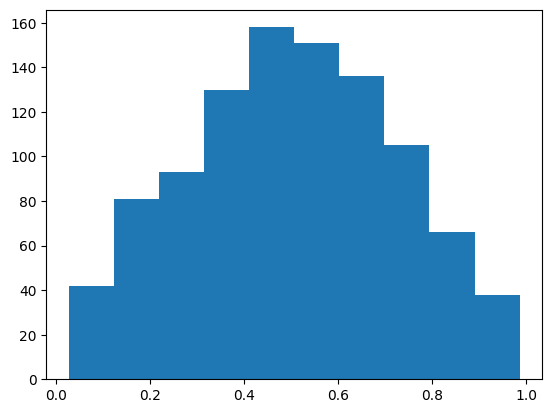

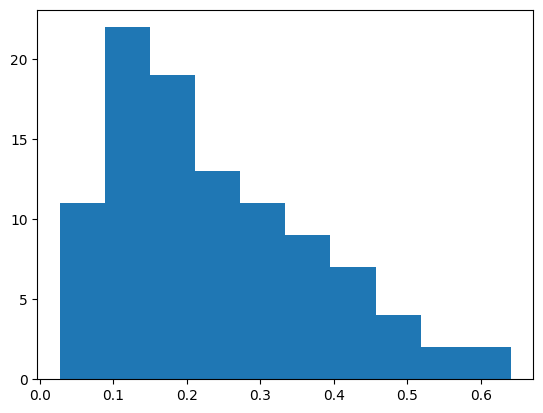

In [7]:
import scipy.stats as st

print(st.t.interval(alpha = 0.99, df = len(total_med_coef)-1, loc = np.mean(total_med_coef), scale = st.sem(total_med_coef)))
print(st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med)) )

#st.t.interval(alpha = 0.99, def = len(total_med_coef) - 1, loc = np.mean(total_med_coef))

#print(st.t.interval(alpha = 0.99, def = len(winner) - 1, loc = np.mean(winner), scale = st.sem(winner)))


plt.hist(total_med_coef)
plt.show()

plt.hist(winner_med)  #   
plt.show()


#  Нормировать количество выживших на окличество обратившихся


## От чего зависит выживаемость НКО?

- График. Сколько кругов смогла пройти организация? И коэффициенты расходов. Сделать 100 симуляций
- Проверить код, точно ли пациенты не идут в мертвые организации
- Предпочтения пациентов. Расходы на пиар в компании и общее количеств вылеченных пациентов. График. Количество выживших пациентов на количество раундов. 

Возможно, выживают лучше организации, которые тратят больше денег на пиар.

- Планы на будущее: сетевые взаимосвязи между пациентами. Граф. Как влияют слухи и социальные связи на организации.
- Эндогенизация правила принятия решений и стратегий.
- Подумать, может, оставлять пациентов на несколько кругов. Каких пациентов оставляем из тех, кто не вылечился. 
- Разные типы диагнозы, возможно, имеют разные значимости для организаций. Дополнительная информация о пациентах. Возраст. Организация может специализироваться на одну возрастную группу или на всех людей.


Если органиазция не берёт пациента, то можно потратить деньги на рекламу или на другого пациента, чтобы выжило большее количество пациентов.


Эффект обучения для донора и для органиазации. Получил сигнал, пожертвовал в раунде органиазации. 

1. Внести коэффициент: какой организации уже жертвовал. Той организации, которой он пожертвовал, тем меньше дисперсии. Об этой организации. Можно сделать дисперсию = 9 / (количество раундов, которой он жертвовал этой организации + 1)

2. Как включить слухи? Вот у нас есть пациенты. Генерируем случайный граф. С помощью Бернулли. Какой коэффициент р? возьмём сейчас 1/2. Можем помоделировать с разными p. Можно сделать двумерное binomial. Эффект репутации можем размножить

Репутационный эффект надо измерять в раунде n+1. А может не только ближайший круг получает сведения? Ближайшее окружение получает чистый сигнал. А вот в дальнейшем получат сигнал репутационный 1/2 или там (1/2)^k, k - количество рёбер между пациентами. 

Пока смотрим ближайшее окружение. 

А что если пациенты будут выживать 

- Узнать, по каким принципам отбирают пациентов. 
- А если компании могут НЕ принять пациента. Берут пациентов, которые скорее всего загнутся без их помощи. Параметр дохода. Может ли человек сам позволить себе лечение? У компании есть экспертиза для разных диагнозов. Мы фиксируем, сколько они тратят на рекламу и лечение. Может, в рамках денег, которые можно потратить на лечение одной болезни или другой. Отбор пациентов на основании распределения Бернулли (параметр р зависит от дохода, типа болезни, вероятность выжить). Ввести разницу между вероятностью выжить без помощи органиазции и с помощью организации. Алгоритм отжига??? Надо понять при каких параметров (берём/не берём каких-то пациентов, распределяем бюджеты)
- Экспертиза. Если есть успешные кейсы дал конкретного диагноза, то в будущем. Выгоднее ли специализироваться на конкретной болезни? 
- Два диагноза с математической точке зрения идентичны. Но компании накапливают опыт в лечении этих диагнозов. Эввективность возрастает пропорционально успешно вылеченных товарищей. А если компания понимает, что человеку нигде не помогут, кроме этой организации, то стимулов будет больше!
- К каким параметрам выживаемости придём в модели в ситуации, если компании обращают внимание на то, чем занимаются конкуренты. 
- Два диагноза
- 
- А если компании берут
- Сделать презентацию про проект.

In [6]:
class SimpleAgentModel:
    class Donators:
        
        def __init__(self):
            self.med_coef = 0
            self.adv_coef = 0
            self.org_pref = 0
            self.prev_donations = 0
            self.reset()
            
        def reset(self):
            self.med_coef = np.random.beta(2, 2, 100)
            self.adv_coef = np.zeros(100, np.float64)
            self.prev_donations = np.zeros((100, 10), np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] > half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            
    class Patients:
        def __init__(self):
            self.med_coef = 0  
            self.adv_coef = 0               
            self.org_pref = 0
            self.choice = 0
            self.p_survival = 0 
            self.visited = 0
            self.budget = 0
            self.count_cured = 0
            self.graph = 0
            self.reset()
            
        def reset(self):
            self.graph = graph = np.random.binomial(n = 1, p = 0.5, size = (100, 100))
            self.med_coef = np.random.beta(2, 2, 100)  #  Какие параметры бета-распредления выставить?
            self.adv_coef = np.zeros(100, np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] < half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
                   
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            self.choice = np.zeros(100, np.int8)
            self.p_survival = np.random.beta(2, 5, 100)  
            self.visited = np.zeros((100, 10), bool)
            self.budget = np.zeros(100, np.int8)
            self.count_cured = np.int8(0)
            
        def new_patient(self, i):
            for j in range(10):
                self.visited[i][j] = False
            self.p_survival[i] = np.random.beta(2, 2)
            self.med_coef[i] = np.random.beta(2, 2)
            if self.med_coef[i] < np.float64(0.5):
                self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
            else:
                self.adv_coef[i] = 1 - self.med_coef[i]
            
    class Organizations:
        def __init__(self):
            self.budget = 0
            self.med_budget = 0
            self.adv_budget = 0
            self.med_coef = 0
            self.is_lose = 0
            self.patients = 0
            self.laps = 0
            self.saved_lives = 0
            self.all_patients = 0
            self.tax = 0
            self.reset()
            
        def reset(self, new_tax = 0):
            self.budget = np.zeros(10, np.uint8)
            self.med_budget = np.zeros(10)
            self.adv_budget = np.zeros(10)
            self.med_coef = np.random.beta(2, 2, 10)  #   Какие параметры бета-распредления выставить?
            self.is_lose = np.zeros(10, bool)
            self.patients = [[] for i in range(10)]
            self.laps = np.zeros(10, np.uint32)
            self.saved_lifes = np.zeros(10, np.uint16)
            self.all_patients = np.zeros(10, np.uint16)
            self.tax = new_tax
    
    def __init__(self):
        self.donators = SimpleAgentModel.Donators()
        self.patients = SimpleAgentModel.Patients()
        self.organizations = SimpleAgentModel.Organizations()
        
    def donation(self):
        for i in range(100): 
            ind = np.argmax(self.donators.org_pref[i]) 
            self.donators.prev_donations[i][ind] += 1
            self.organizations.budget[ind] += 1        
            
    def budget_med_or_adv(self):                    #  Сделать долевым!!  
        for i in range(10):
            if self.organizations.budget[i] == 0:
                self.organizations.is_lose[i] = True
            else:
                self.organizations.laps[i] += 1
                self.organizations.med_budget[i] = self.organizations.budget[i] * self.organizations.med_coef[i]
                self.organizations.adv_budget[i] = (self.organizations.budget[i] - self.organizations.med_budget[i]) * (1 - self.organizations.tax)
                self.organizations.budget[i] = 0
        #print(f'{self.organizations.med_budget = }\n{self.organizations.adv_budget = }')

    def choose_organization(self):  
        for i in range(100):
            for j in range(10):
                if self.patients.visited[i][j] or self.organizations.is_lose[j]:
                    self.patients.org_pref[i][j] = -100
                    continue
                a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
            ind = np.argmax(self.patients.org_pref[i]) 
            if self.patients.org_pref[i][ind] == -100:
                for j in range(10):
                    self.patients.visited[i][j] = False
                    if not self.organizations.is_lose[j]:
                        a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                        self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
                ind = np.argmax(self.patients.org_pref[i])
                   
            self.patients.visited[i][ind] = True
            self.patients.choice[i] = ind
            self.organizations.all_patients[ind] += 1
            self.organizations.patients[ind].append(i)
                                                                                                                                                
    def budget_between_patient(self): #  Может ли организация не принять?
        for i in range(10):
            if (self.organizations.is_lose[i]):
                continue
            survive = [self.patients.p_survival[self.organizations.patients[i][j]] for j in range(len(self.organizations.patients[i]))]
            surv_sum = sum(survive)
            proportion = [prob / surv_sum for prob in survive]
            for j in range(len(self.organizations.patients[i])):
                ind = self.organizations.patients[i][j]
                self.patients.budget[ind] = proportion[j] * self.organizations.med_budget[i]            
            self.organizations.patients[i] = []
        
    def survival(self):                 #  поменять коэффициенты в ???
        for i in range(100):            #  logit ~ (0.5, 1) - p выживаемости. 
                                        #  У нас в любом случае высокая вероятность выжить!!

            s_i = (1 / (1 + math.pow(math.e, -(-0.5 + self.patients.p_survival[i] + 0.01 * self.patients.budget[i]) ))) - 0.2
            
            if np.random.binomial(1, s_i): #  Пациент вылечился (Биномиальное распределение)
                self.patients.count_cured += 1
                self.patients.new_patient(i)
                self.organizations.saved_lifes[self.patients.choice[i]] += 1
        
    def set_new_preferences(self):   #  Коэффициенты предпочтения организации
        for i in range(100):
            for j in range(10):
                if self.organizations.is_lose[j]:
                    self.donators.org_pref[i][j] = -100
                    continue
                a = self.donators.med_coef[i] * self.organizations.med_budget[j] + self.donators.adv_coef[i] * self.organizations.adv_budget[j]
                self.donators.org_pref[i][j] = np.random.normal(a, 9 / (1 + self.donators.prev_donations[i][j]))
        self.organizations.budget = np.zeros(10, np.int8)
        self.organizations.med_budget = np.zeros(10, np.int8)
        self.organizations.adv_budget = np.zeros(10, np.int8)
        
    
    def lap(self):
        self.donation()
        #print('Budgets of org:', end = ' ')
        #for i in range(10):
        #    print(self.organizations.budget[i], end = ', ')
        #print()
        
        self.budget_med_or_adv()
        self.choose_organization()
        
        #print(f'Количество пациентов организации:', end = ' ')
        #for i in range(10):
        #    print(len(self.organizations.patients[i]), end = ', ')
        #print()
        self.budget_between_patient()
        self.survival()
        #print(f'Количество вылечившихся: {self.patients.count_cured}')
        self.set_new_preferences()
        
    def simulation(self):
        self.donators.reset()
        self.patients.reset()
        self.organizations.reset(self.organizations.tax)
        i = 0
        while True:
            i += 1
            self.lap()
            if sum(self.organizations.is_lose == True) == 9:
                winner_ind = 0
                for j in range(10):
                    if not self.organizations.is_lose[j]:
                        winner_ind = j
                        break
                #print(f'laps: {i}, saved: {self.patients.count_cured}, per_lap: {self.patients.count_cured / i}')
                return i, self.organizations.laps, self.organizations.med_coef, self.organizations.saved_lifes, self.organizations.all_patients, winner_ind
            
   

array([0.29696495, 0.42148903, 0.41320624, 0.21900312, 0.06908893,
       0.05531646, 0.02595043, 0.16326471, 0.14294161, 0.02682021,
       0.63833639, 0.60241035, 0.21110696, 0.3967288 , 0.30645486,
       0.14118401, 0.53650609, 0.43303714, 0.08474276, 0.3339697 ,
       0.15422696, 0.38666664, 0.14732879, 0.30641388, 0.47763517,
       0.26761543, 0.40000439, 0.16880908, 0.15707735, 0.11631147,
       0.35217522, 0.18699849, 0.24096939, 0.34382157, 0.14331722,
       0.21425546, 0.14636779, 0.12173096, 0.35115837, 0.04544667,
       0.10532397, 0.27564162, 0.52823857, 0.15449854, 0.47996704,
       0.60627874, 0.23290468, 0.24891837, 0.21631346, 0.16022058,
       0.22772398, 0.37418234, 0.16114981, 0.19109779, 0.20991056,
       0.20305966, 0.12218463, 0.33982402, 0.10898496, 0.24166226,
       0.34904829, 0.1474977 , 0.37057498, 0.12267   , 0.28376725,
       0.19808586, 0.31956597, 0.14076523, 0.23711089, 0.19349335,
       0.4968486 , 0.50955636, 0.33490942, 0.30154593, 0.31814

In [ ]:
graph = np.random.binomial((100, 100), n = 1, p = 0.5)
graph

### Model.organizations.tax = 0.5, 100 кругов

total_med_coef  (0.478473788192293, 0.5159742218115281)winner_med_coef 
(0.2814654411924406, 0.4049937496454516

number of laps and total med coef. 

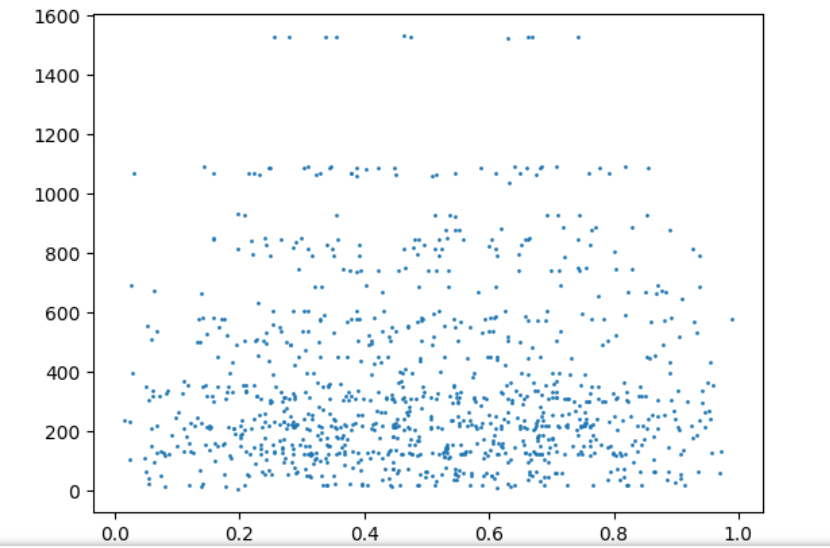

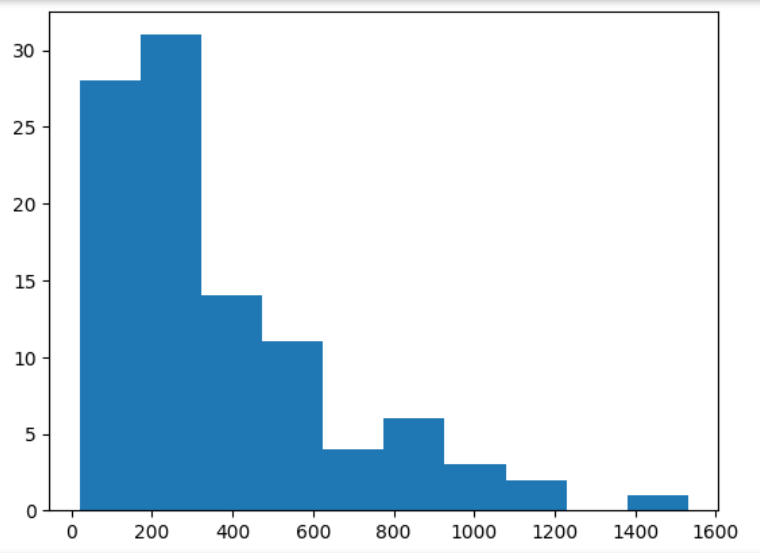

med coef, winner med coef
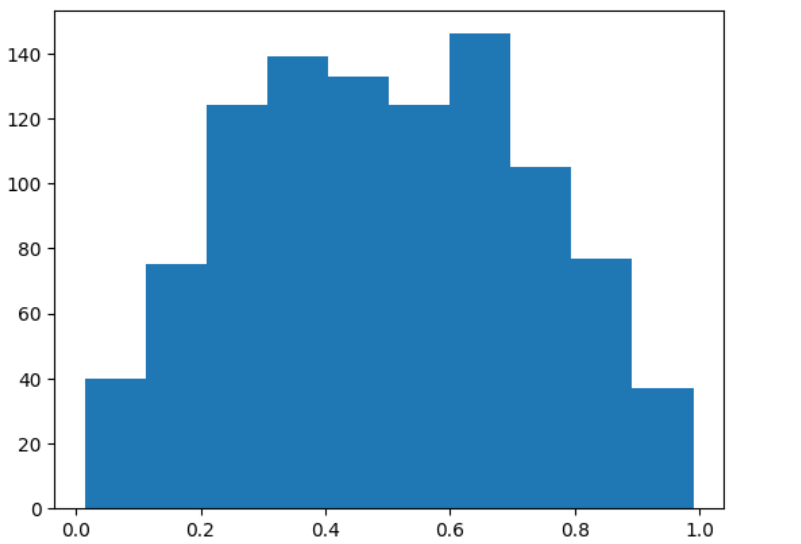
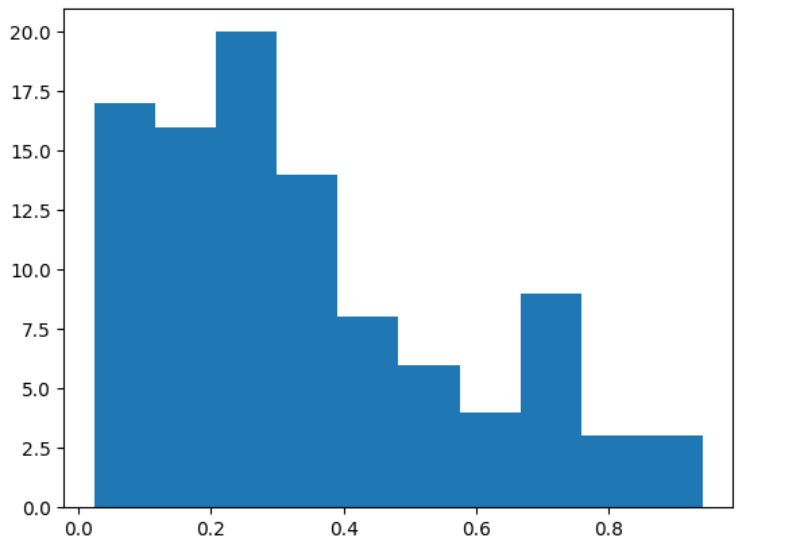eaeb4.png)

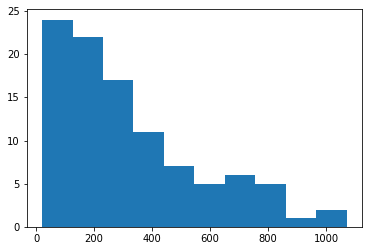

### Результаты по налогам: ничего не меняется при налоге
- Возможно, сами затраты никак не влияют на выживаемость. Надо подкорректировать коэффициенты

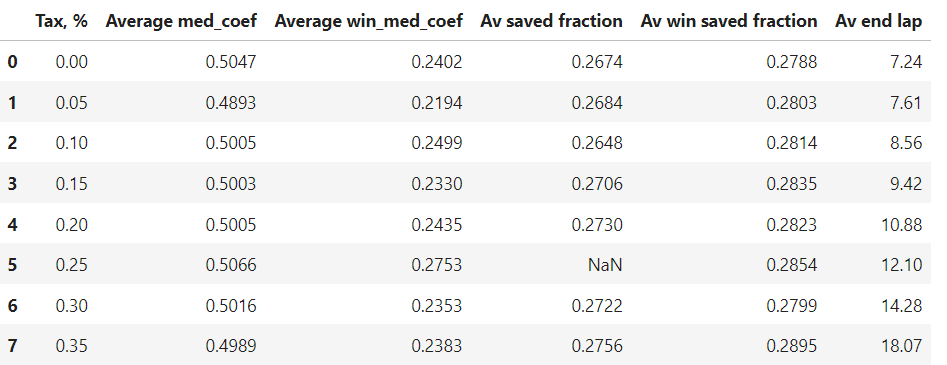
А вот это, если дисперсия уменьшается, если доноры уже донатили организации
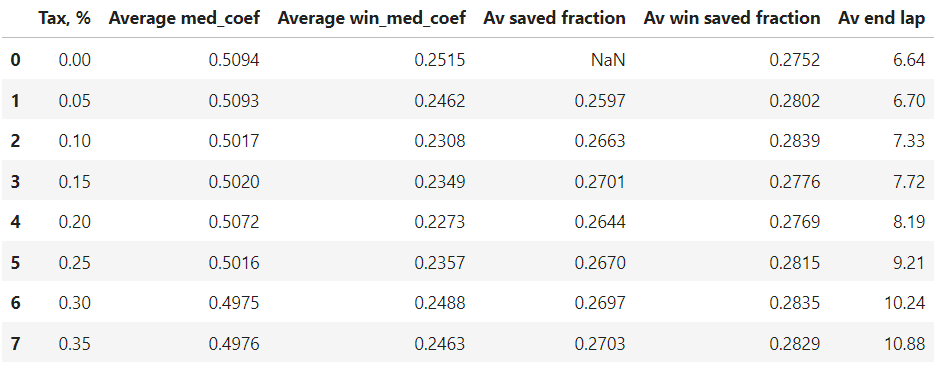

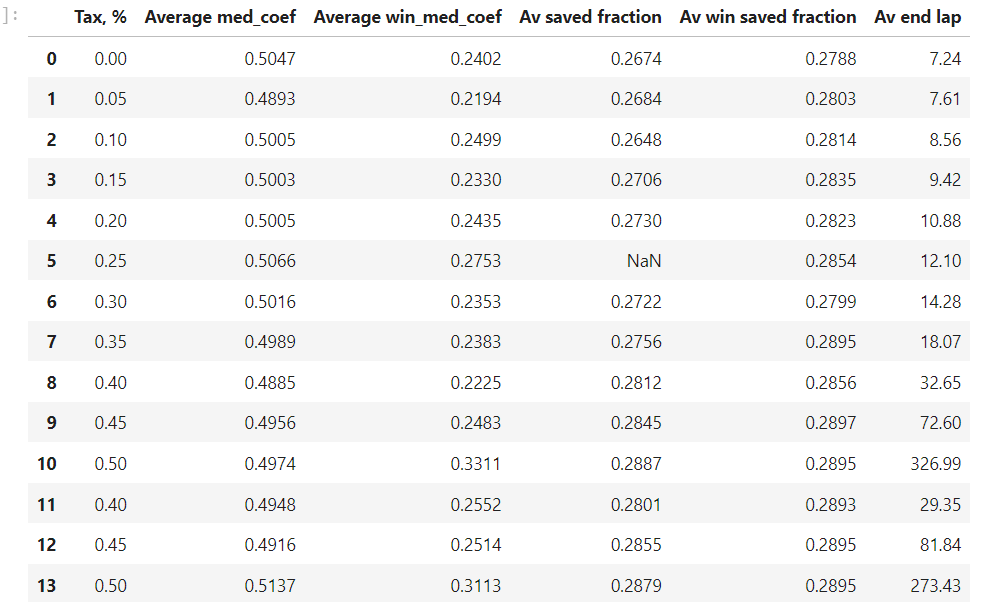